In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import tqdm

In [11]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [12]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

In [15]:
def train_episode(env, policy, optimizer, discount_factor, epsilon, device):
    """Train policy for one episode."""
    policy.train()
    episode_reward = 0
    done = False
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        # --- Epsilon-greedy action selection ---
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_pred = policy(state)
                action = torch.argmax(q_pred, dim=1).item()

        # --- Take step in environment ---
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # next_state = torch.as_tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        # --- Update policy ---
        loss = update_policy(policy, state, action, reward, next_state, discount_factor, optimizer)

        # --- Transition ---
        state = next_state
        episode_reward += reward

    return loss, episode_reward, epsilon

In [16]:
def update_policy(policy, state, action, reward, next_state, discount_factor, optimizer):
    q_preds = policy(state)
    q_vals = q_preds[:, action]
    with torch.no_grad():
        q_next_preds = policy(next_state)
        q_next_vals = q_next_preds.max(1).values
        targets = reward + q_next_vals * discount_factor
    loss = F.smooth_l1_loss(q_vals, targets.detach())
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
    optimizer.step()
    return loss.item()

In [17]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_pred = policy(state)
            action = torch.argmax(q_pred).item()

        # state, reward, done, _ = env.step(action)
        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state

    return total_reward

In [18]:

train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

SEED = 333
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device_ = get_device()
# device_ = torch.device("cpu")

input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

n_runs = 10
n_episodes = 500
discount_factor = 0.8
start_epsilon = 1.0
end_epsilon = 0.01
epsilon_decay = 0.995

train_rewards = torch.zeros(n_runs, n_episodes)
test_rewards = torch.zeros(n_runs, n_episodes)

for run in range(n_runs):
    policy_ = MLP(input_dim, hidden_dim, output_dim).to(device_)
    policy_.apply(init_weights)
    epsilon = start_epsilon
    optimizer_ = optim.RMSprop(policy_.parameters(), lr=1e-6)
    for episode in tqdm.tqdm(range(n_episodes), desc=f'Run: {run}'):
        loss, train_reward, epsilon = train_episode(train_env, policy_, optimizer_, discount_factor, epsilon, device_)
        epsilon *= epsilon_decay
        epsilon = min(epsilon, end_epsilon)
        test_reward = evaluate(test_env, policy_, device_)
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward

Using device: cuda


Run: 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 123.72it/s]


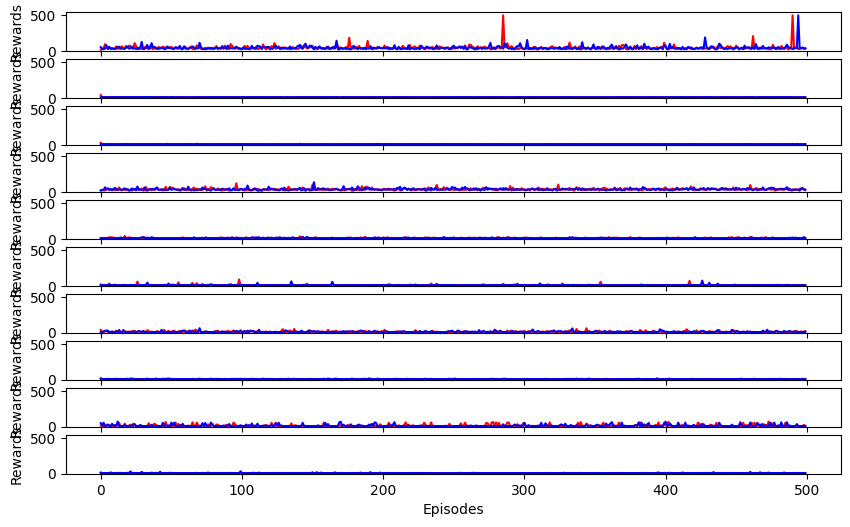

In [19]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i], c='red')
    _ax.plot(idxs, test_rewards[i], c='blue')
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

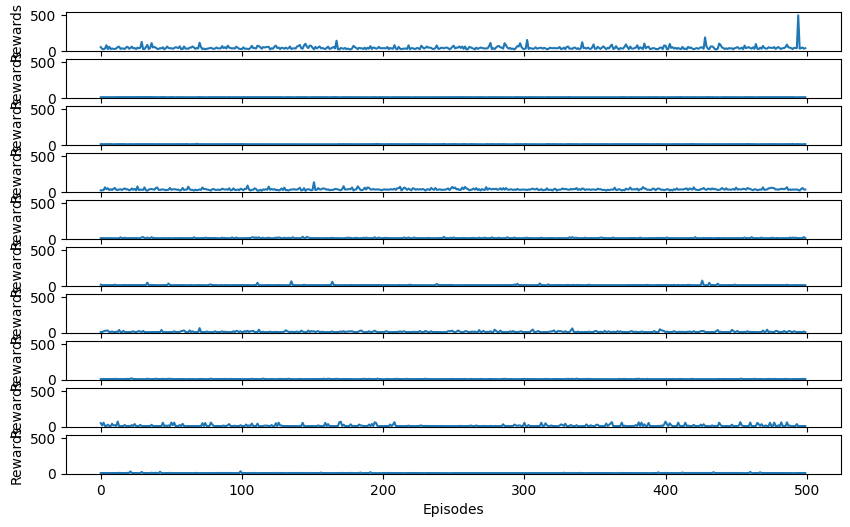

In [20]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, test_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

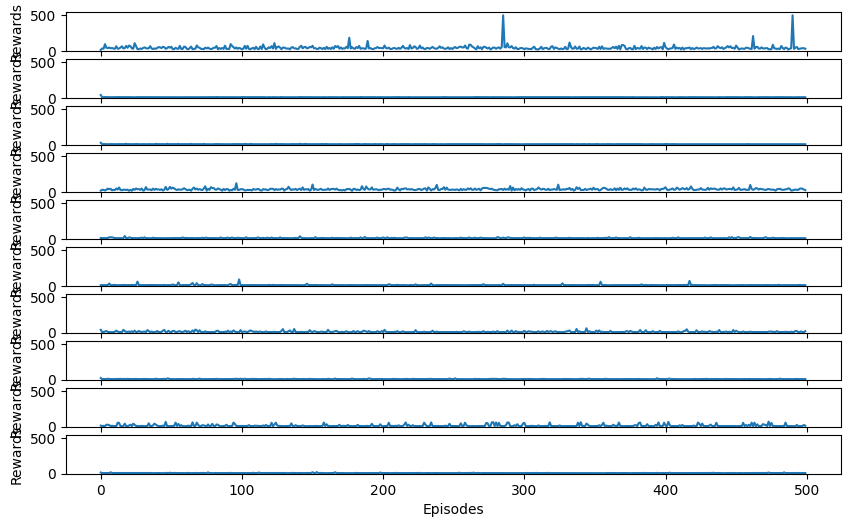

In [21]:
idxs = range(n_episodes)
fig, ax = plt.subplots(n_runs, figsize=(10,6))
for i, _ax in enumerate(ax):
    _ax.plot(idxs, train_rewards[i])
    _ax.set_ylim(0, 550)
    _ax.set_ylabel('Rewards');
    if i == n_runs - 1:
        _ax.set_xlabel('Episodes')

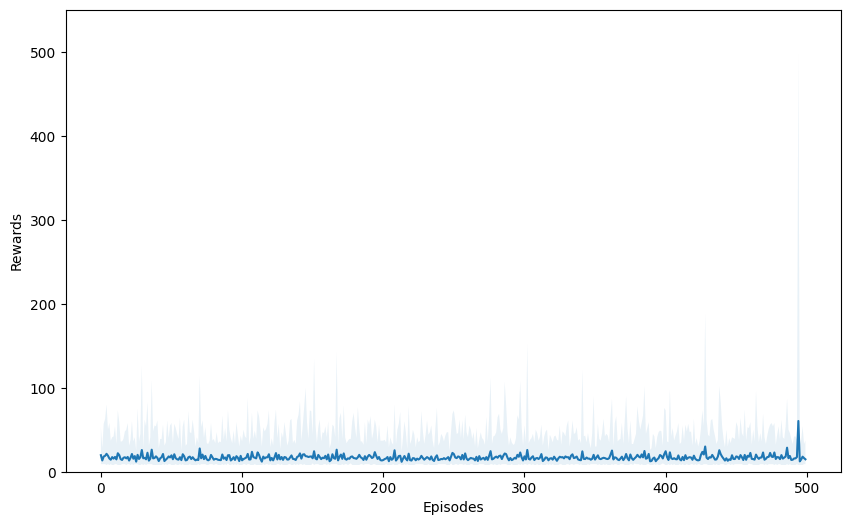

In [22]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.set_ylim(0, 550)
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

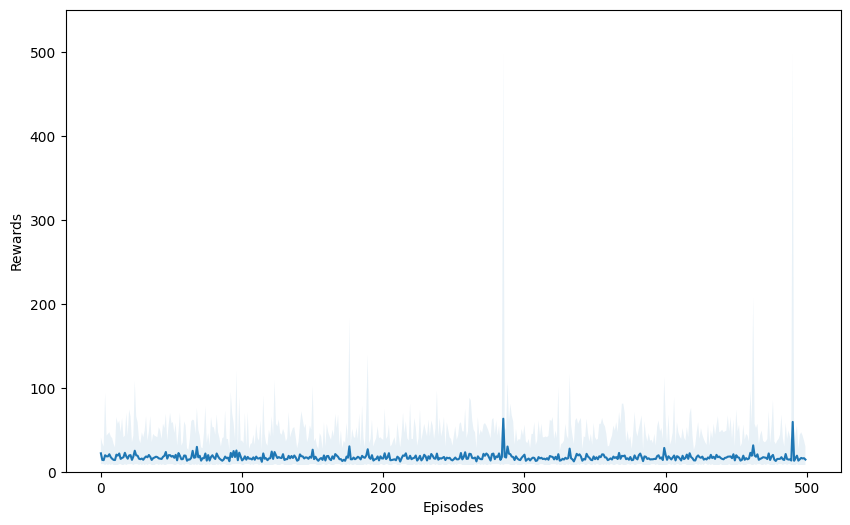

In [23]:
idxs = range(n_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, train_rewards.mean(0))
ax.set_ylim(0, 550)
ax.fill_between(idxs, train_rewards.min(0).values, train_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards');

0.995


(0.0, 1.1)

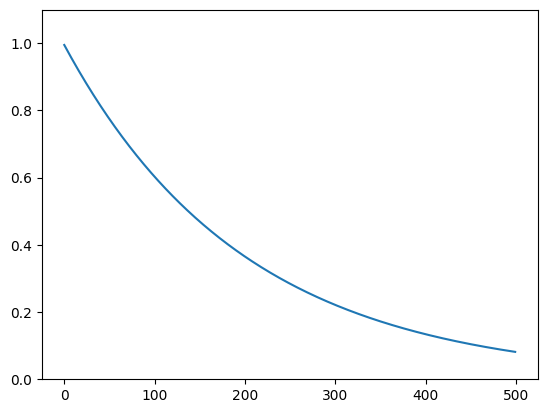

In [24]:
n = 500
start_x = 1.0
decay = 0.995
print(decay)
min_x = 0.01
x = start_x
ys = []
for i in range(n):
    x *= decay
    x = max(x, min_x)
    ys.append(x)
plt.plot(ys)
plt.ylim(0,1.1)

In [25]:
np.e

2.718281828459045

In [26]:
q = collections.deque(maxlen=5)

In [27]:
q

deque([], maxlen=5)

In [28]:
len(q)

0

In [29]:
q.append(1)

In [30]:
20_000/500

40.0

In [31]:
q.maxlen

5

In [32]:
q.append(1)
q.append(1)
q.append(1)
q.append(1)

In [33]:
len(q)

5

In [34]:
q.append(1)
q.append(1)
q.append(1)
q.append(1)

In [35]:
q

deque([1, 1, 1, 1, 1], maxlen=5)

In [36]:
len(q)

5